# Text Yourself When GPUs Are Available

Nate Raw  
2023-07-24

GPUs - so hot right now! It’s getting to the point where all available
GPU instances are unavailable, which is a bummer if you’re trying to
train a model.

As of writing this, Lambda Cloud is my favorite cloud GPU provider. They
have great instances, an easy to use UI, and the best prices. The only
downside is that they’re often sold out. So, let’s see what we can do
about that.

## The Plan

To make things easier, I put together a small Python library called
[lambdacloud](https://github.com/nateraw/lambdacloud) that makes it easy
to interface with the Lambda Cloud API. We’ll use this to check for
available instances and spin them up.

We’ll also use [Twilio](https://twilio.com) to send text messages.
You’ll need a Twilio account and a phone number that can send SMS
messages.

To avoid having to run this script all the time from your local machine,
we’ll use [Modal](https://modal.com) to run the script on a schedule.
Modal is a cloud orchestration platform that makes it easy to run code
on cloud machines. Using it for this use case shouldn’t cost more than a
few cents, but you can just follow along with the code and run it
locally if you prefer.

In [ ]:
! pip install lambdacloud twilio modal-client

You’ll need to authenticate with Modal if you haven’t already…

In [ ]:
! modal token new

To authenticate with Lambda’s API, you’ll need an API key, which you can
generate [here](https://cloud.lambdalabs.com/api-keys) when you’re
logged in.

Additionally, you’ll need Twilio’s account identifier, auth token, and
phone number, which you can find [here](https://www.twilio.com/console).
The phone number will be the one you’ll receive texts from, and it
should be fairly easy to figure out how to set that up if you haven’t
already.

Now that we have all our credentials, we’ll log into Modal and create a
collection of secrets. See the docs on this feature
[here](https://modal.com/docs/guide/secrets).

I’ve named my collection “twilio” and added the following environment
variables: - `TWILIO_SID`: Twilio account identifier - `TWILIO_AUTH`:
Your Twilio auth token - `TWILIO_PHONE`: Your Twilio phone number (Make
sure to include the country code, e.g. +1 for US) - `TO_PHONE`: Your
phone number you want to receive texts on (Make sure to include the
country code, e.g. +1 for US) - `LAMBDA_SECRET`: Your Lambda Labs Cloud
API Key

<figure>
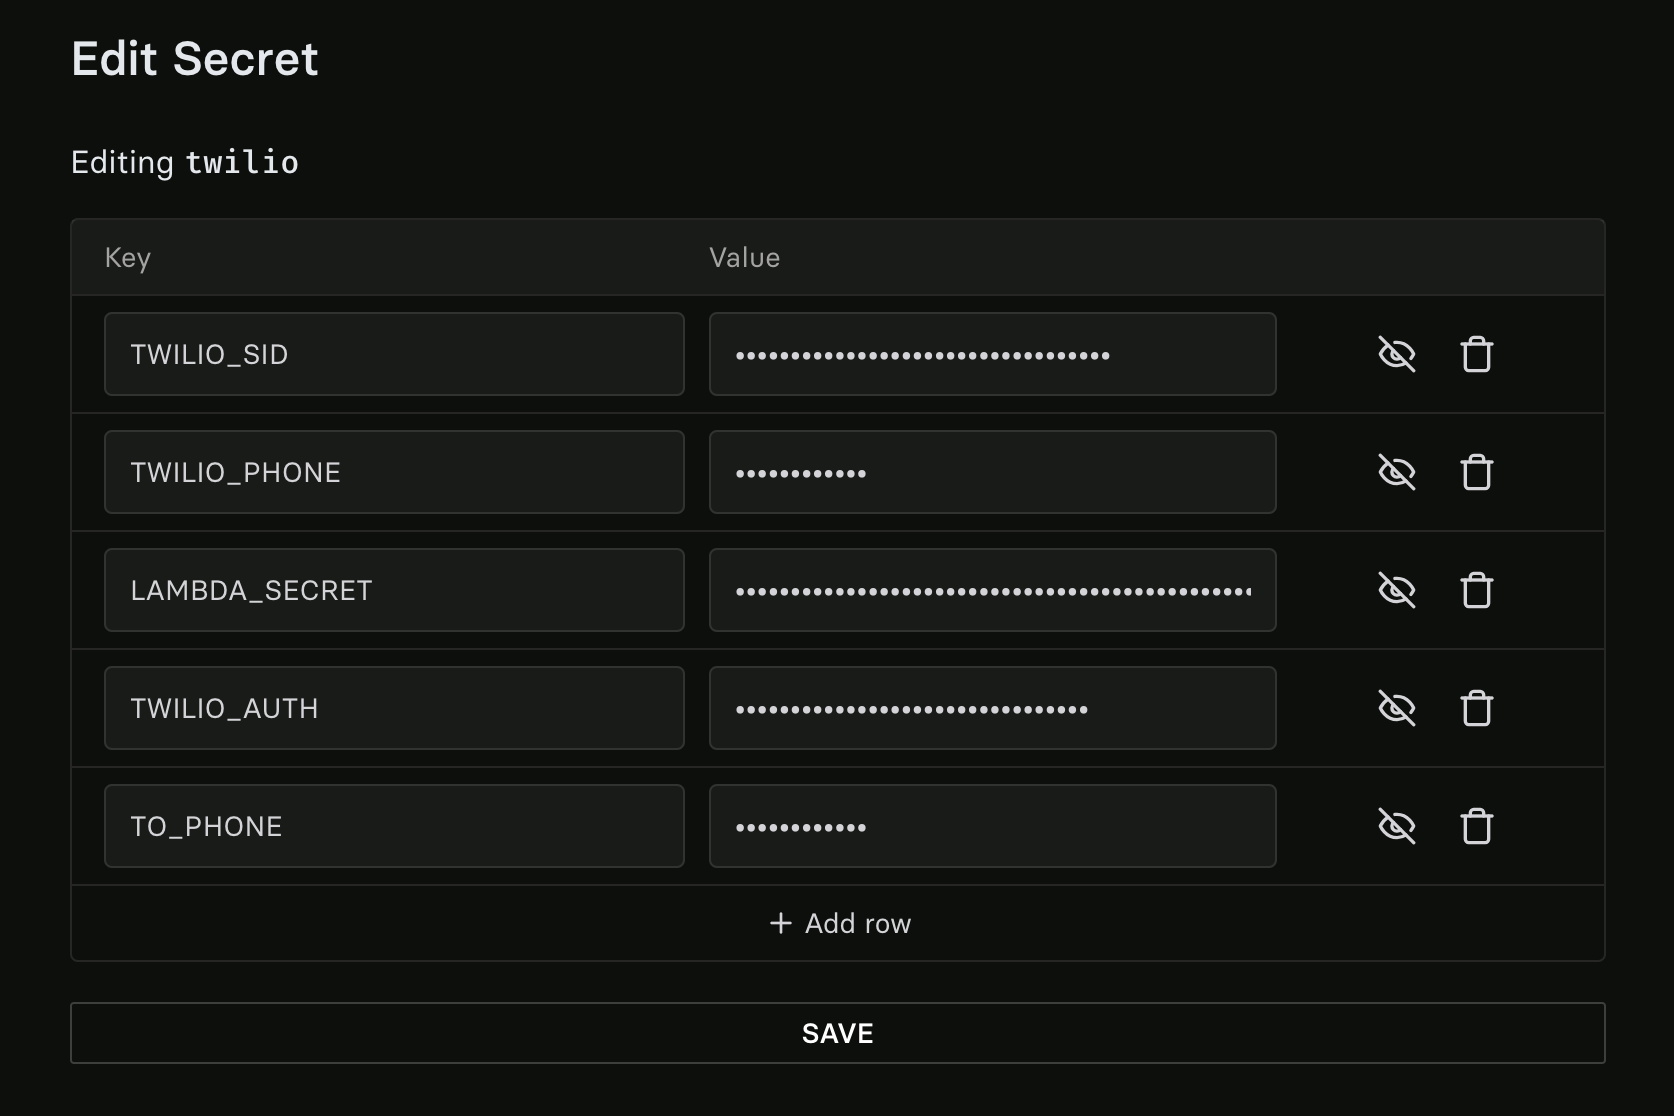
<figcaption aria-hidden="true">Modal Secrets</figcaption>
</figure>

## The Code

Everything’s ready, we just have to write a small script now 🚀. Here it
is:

In [ ]:
import os

import modal


stub = modal.Stub()

# Defines our environment, installs necessary packages
my_image = modal.Image.debian_slim().pip_install("lambdacloud", "twilio")

# Replace these with your own values
DESIRED_INSTANCE_TYPES = ["gpu_8x_a100_80gb_sxm4", "gpu_8x_a100", "gpu_8x_v100"]


@stub.function(image=my_image, schedule=modal.Cron("*/5 3-9 * * 1-5"), secret=modal.Secret.from_name("twilio"))
def poll_lambda_for_big_instances():
    from lambdacloud import list_instance_types, login
    from twilio.rest import Client

    # Auth with lambda
    login(token=os.environ["LAMBDA_SECRET"])

    # Auth with twilio
    account_sid = os.environ["TWILIO_SID"]
    auth_token = os.environ["TWILIO_AUTH"]
    client = Client(account_sid, auth_token)

    from_phone = os.environ["TWILIO_PHONE"]
    to_phone = os.environ["TO_PHONE"]

    instances_available = [x.name for x in list_instance_types()]
    nl = "\n"
    print(f"Instances available:{nl}✅ - {f'{nl}✅ - '.join(instances_available)}")

    desired_instances_available = []
    for desired_instance in DESIRED_INSTANCE_TYPES:
        if desired_instance in instances_available:
            desired_instances_available.append(desired_instance)

    if len(desired_instances_available):
        body = f"The following instances are available on Lambda Cloud: {', '.join(desired_instances_available)}."
        message = client.messages.create(from_=from_phone, to=to_phone, body=body)
        print(f"Message sent - SID: {message.sid}")

if __name__ == "__main__":
    modal.runner.deploy_stub(stub, name="lambda-watcher")

If all went well, you should get a text message when an instance becomes
available. You can also check the logs in Modal to see what’s going on.
In the UI, you should see something like this for the deployment:

<figure>
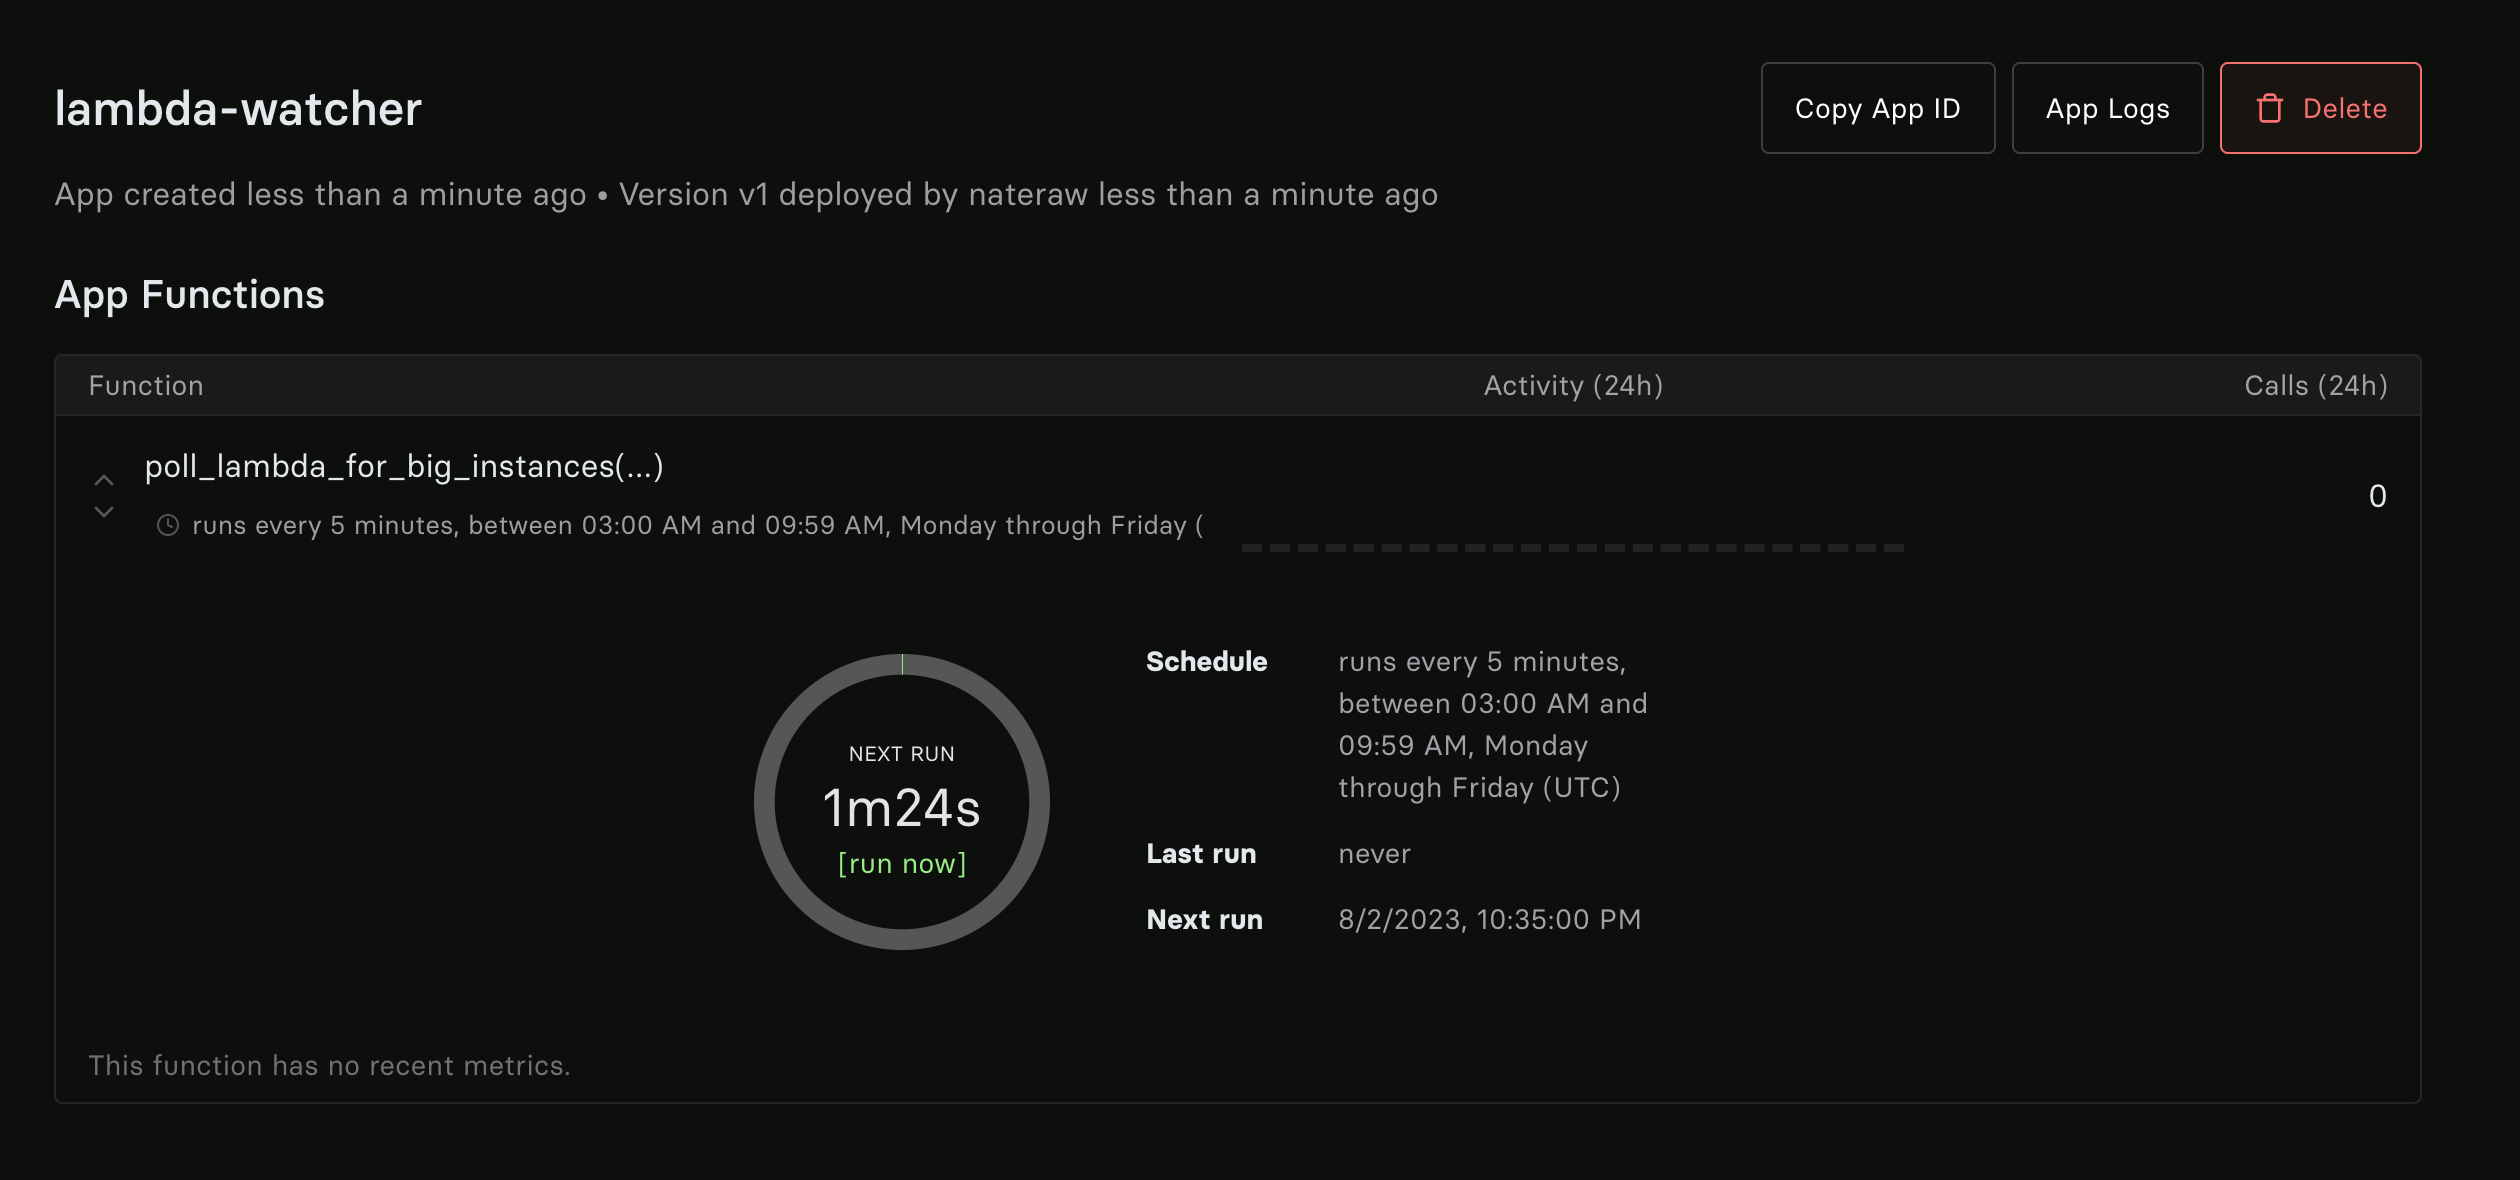
<figcaption aria-hidden="true">Modal Logs</figcaption>
</figure>

That’s it! Now you can text yourself when GPUs are available. It’s
fairly easy to extend this script to spin up instances that are
available, just use the `lambdacloud.create_instance` function. I’ll
leave that to you as homework 😎.